## 📝 Homework 1 Summary

### Part 1 – Multi-Armed Bandit
- **Run** the BanditLab notebook with at least three exploration strategies (ε-greedy with different ε, UCB, Softmax).
- ε-greedy with different ε means to compare different ε values and select one to compare agains UCB and Softmax. A similar strategy might be needed regarding temperature at Softmax and exploratory constant in UCB.

- **Collect**:
  - Average reward vs. time
  - % Optimal action vs. time
- **Write** a short paragraph explaining:
  - How exploration parameter (ε, c, τ) affected performance
  - Which strategy seemed best and why

### Part 2 – FrozenLake MDP (due after Session 2)
- **Run** the FrozenLake notebook:
  - Print number of states and actions
  - Inspect sample transition probabilities
  - Run ≥20 random-policy episodes; compute average reward and episode length
  - Estimate
- **Write** a short paragraph explaining:
  - Differences between FrozenLake and the bandit problem
  - What an agent might need to improve performance

### Deliverables
- Submit both notebooks (with plots and outputs).
- Submit the two reflection paragraphs (one per part).

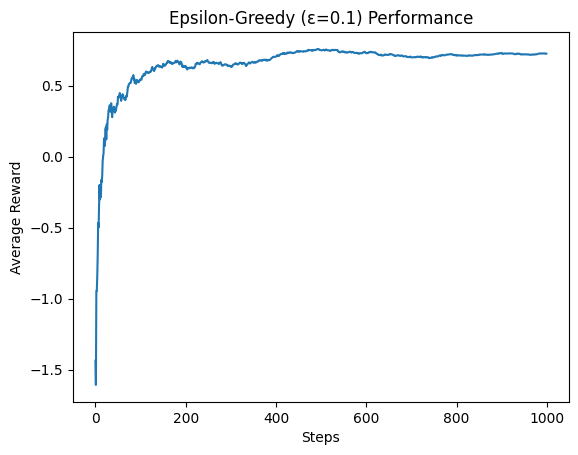

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

class Bandit:
    def __init__(self, n_arms):
        self.n_arms = n_arms
        # true means of each arm (hidden from agent)
        self.true_means = np.random.normal(0, 1, n_arms)
        self.estimates = np.zeros(n_arms)
        self.counts = np.zeros(n_arms)

    def pull(self, arm):
        # stochastic reward from selected arm
        return np.random.normal(self.true_means[arm], 1)

    def update_estimate(self, arm, reward):
        self.counts[arm] += 1
        alpha = 1 / self.counts[arm]
        self.estimates[arm] += alpha * (reward - self.estimates[arm])

def epsilon_greedy(estimates, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(len(estimates))
    else:
        return np.argmax(estimates)

# Example run
bandit = Bandit(n_arms=10)
epsilon = 0.1
rewards = []

for t in range(1000):
    action = epsilon_greedy(bandit.estimates, epsilon)
    reward = bandit.pull(action)
    bandit.update_estimate(action, reward)
    rewards.append(reward)

plt.plot(np.cumsum(rewards) / np.arange(1, len(rewards)+1))
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.title(f'Epsilon-Greedy (ε={epsilon}) Performance')
plt.show()


In [34]:
class BanditEnv:
    def __init__(self, n, sigma=1.0, seed=0, nonstationary=False, drift=0.01):
        rng = np.random.default_rng(seed)
        self.n, self.sigma, self.rng = n, sigma, rng
        self.mu = rng.normal(0, 1, n)     # hidden true means
        self.nonstationary, self.drift = nonstationary, drift
    def step(self, a):
        if self.nonstationary:
            self.mu += self.rng.normal(0, self.drift, self.n)  # gentle random walk
        r = self.rng.normal(self.mu[a], self.sigma)
        return float(r)

class EpsilonGreedyAgent:
    def __init__(self, n, epsilon=0.1):
        self.epsilon = epsilon
        self.Q = np.zeros(n); self.N = np.zeros(n, dtype=int)
    def act(self):
        return np.random.randint(len(self.Q)) if np.random.rand() < self.epsilon else int(np.argmax(self.Q))
    def update(self, a, r):
        self.N[a] += 1
        self.Q[a] += (r - self.Q[a]) / self.N[a]


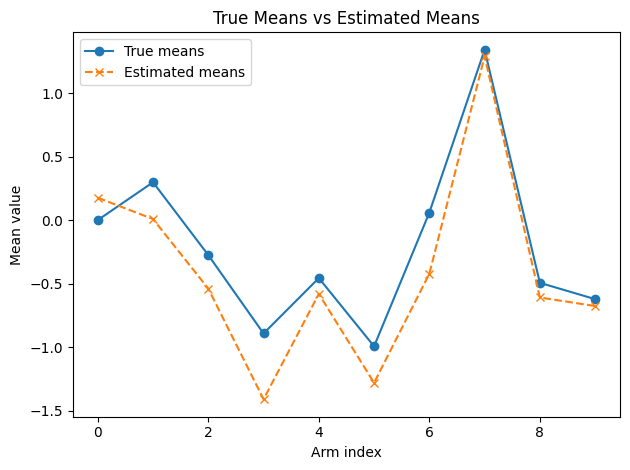

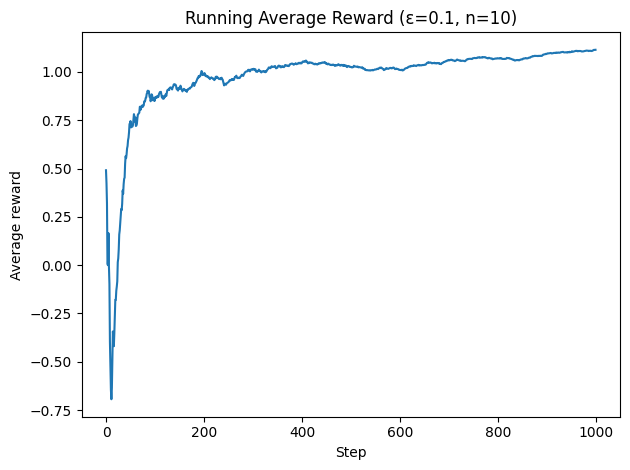

Best arm: 7 (true mean=1.340)
Agent thinks best arm: 7 (estimated mean=1.289)
Final average reward: 1.115


In [35]:
# --- Run an experiment with the BanditEnv and EpsilonGreedyAgent ---

# Parameters you can tweak
n_arms = 10          # number of arms
epsilon = 0.1        # exploration rate
steps = 1000         # total steps
seed = 7             # random seed for reproducibility
nonstationary = False
drift = 0.01         # drift if nonstationary=True

# Create environment and agent
env = BanditEnv(n=n_arms, seed=seed, nonstationary=nonstationary, drift=drift)
agent = EpsilonGreedyAgent(n=n_arms, epsilon=epsilon)

# Lists to store actions and rewards
rewards = []
actions = []

# Main loop
for t in range(steps):
    a = agent.act()            # select action
    r = env.step(a)            # get reward from environment
    agent.update(a, r)         # update estimate
    rewards.append(r)
    actions.append(a)

# Convert to numpy arrays
import numpy as np
rewards = np.array(rewards, dtype=float)
avg_reward = np.cumsum(rewards) / np.arange(1, steps + 1)

# --- Plot current estimates vs true means ---
import matplotlib.pyplot as plt

plt.figure()
x = np.arange(n_arms)
plt.plot(x, env.mu, marker='o', linestyle='-', label='True means')
plt.plot(x, agent.Q, marker='x', linestyle='--', label='Estimated means')
plt.xlabel('Arm index')
plt.ylabel('Mean value')
plt.title('True Means vs Estimated Means')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# --- Plot average reward over time ---
plt.figure()
plt.plot(avg_reward)
plt.xlabel('Step')
plt.ylabel('Average reward')
plt.title(f'Running Average Reward (ε={epsilon}, n={n_arms})')
plt.tight_layout()
plt.show()

# Quick summary
best_arm = int(np.argmax(env.mu))
estimated_best = int(np.argmax(agent.Q))
print(f"Best arm: {best_arm} (true mean={env.mu[best_arm]:.3f})")
print(f"Agent thinks best arm: {estimated_best} (estimated mean={agent.Q[estimated_best]:.3f})")
print(f"Final average reward: {avg_reward[-1]:.3f}")


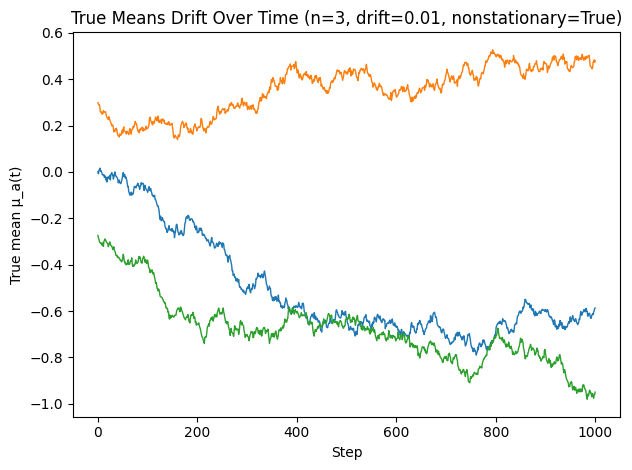

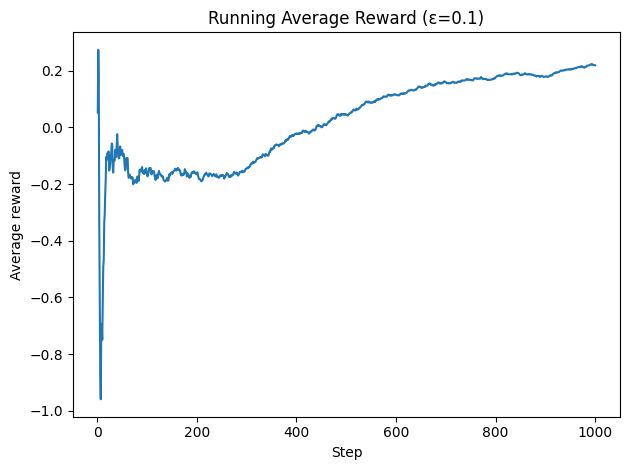

Final best arm: 1 (true mean=0.480)
Agent's estimated best: 1 (Q=0.450)
Total best-arm switches observed: 0


In [36]:
# --- Run an experiment and visualize DRIFT of true means over time ---

# Parameters
n_arms = 3
epsilon = 0.1
steps = 1000
seed = 7
nonstationary = True   # set True to see drift
drift = 0.01           # magnitude of random-walk per step (std dev)

# Create environment and agent
env = BanditEnv(n=n_arms, seed=seed, nonstationary=nonstationary, drift=drift)
agent = EpsilonGreedyAgent(n=n_arms, epsilon=epsilon)

# Storage
import numpy as np
rewards = np.empty(steps, dtype=float)
actions = np.empty(steps, dtype=int)
mu_hist = np.empty((steps+1, n_arms), dtype=float)  # store mu BEFORE each step (t=0..steps)
best_arm_hist = np.empty(steps+1, dtype=int)

# Initial snapshot of means & best arm
mu_hist[0] = env.mu.copy()
best_arm_hist[0] = int(np.argmax(mu_hist[0]))

# Main loop
for t in range(steps):
    a = agent.act()
    r = env.step(a)
    agent.update(a, r)
    rewards[t] = r
    actions[t] = a
    mu_hist[t+1] = env.mu.copy()
    best_arm_hist[t+1] = int(np.argmax(mu_hist[t+1]))

# Metrics
avg_reward = np.cumsum(rewards) / np.arange(1, steps + 1)
best_arm_switches = int(np.sum(best_arm_hist[1:] != best_arm_hist[:-1]))

# --- Plots ---
import matplotlib.pyplot as plt

# 1) True means over time (shows drift and possible best-arm swaps)
plt.figure()
time = np.arange(steps+1)
for a in range(n_arms):
    plt.plot(time, mu_hist[:, a], linewidth=1)
plt.xlabel('Step')
plt.ylabel('True mean μ_a(t)')
plt.title(f'True Means Drift Over Time (n={n_arms}, drift={drift}, nonstationary={nonstationary})')
plt.tight_layout()
plt.show()

# 2) Running average reward
plt.figure()
plt.plot(np.arange(1, steps+1), avg_reward)
plt.xlabel('Step')
plt.ylabel('Average reward')
plt.title(f'Running Average Reward (ε={epsilon})')
plt.tight_layout()
plt.show()



# Quick summary
final_best = int(np.argmax(env.mu))
print(f"Final best arm: {final_best} (true mean={env.mu[final_best]:.3f})")
print(f"Agent's estimated best: {int(np.argmax(agent.Q))} (Q={agent.Q.max():.3f})")
print(f"Total best-arm switches observed: {best_arm_switches}")


## Running with different epsilons

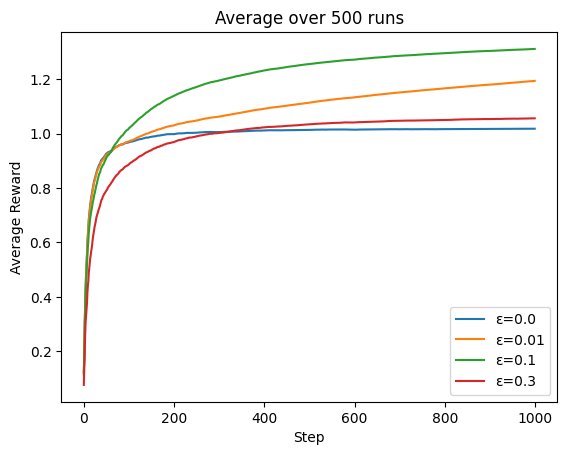

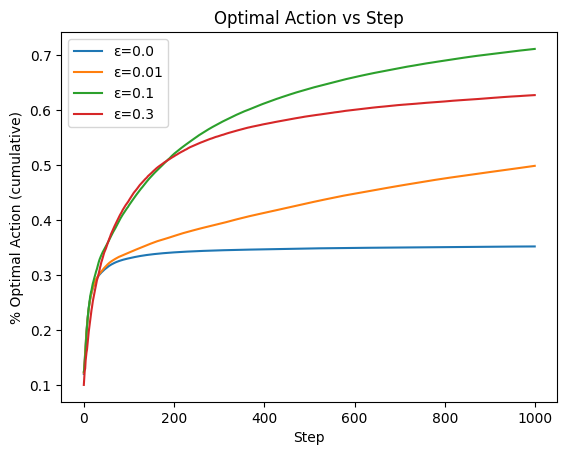

In [37]:
epsilons = [0.0, 0.01, 0.1, 0.3]
runs = 500          # large number
steps = 1000
n_arms = 10

avg_rewards_all = {eps: np.zeros(steps) for eps in epsilons}
optimal_action_counts = {eps: np.zeros(steps) for eps in epsilons}

for eps in epsilons:
    for run in range(runs):
        env = BanditEnv(n=n_arms, seed=run, nonstationary=False)
        agent = EpsilonGreedyAgent(n=n_arms, epsilon=eps)
        best_arm = int(np.argmax(env.mu))  # the true optimal arm
        for t in range(steps):
            a = agent.act()
            r = env.step(a)
            agent.update(a, r)
            avg_rewards_all[eps][t] += r

            if a == best_arm:
                optimal_action_counts[eps][t] += 1

    avg_rewards_all[eps] /= runs
    optimal_action_counts[eps] /= runs

plt.figure()
for eps in epsilons:
    avg_reward = np.cumsum(avg_rewards_all[eps]) / np.arange(1, steps+1)
    plt.plot(avg_reward, label=f'ε={eps}')
plt.xlabel('Step'); plt.ylabel('Average Reward')
plt.title(f'Average over {runs} runs')
plt.legend()
plt.show()

# --- Plot % Optimal Action ---
plt.figure()
for eps in epsilons:
    pct_optimal = np.cumsum(optimal_action_counts[eps]) / np.arange(1, steps+1)
    plt.plot(pct_optimal, label=f'ε={eps}')
plt.xlabel('Step')
plt.ylabel('% Optimal Action (cumulative)')
plt.title(f'Optimal Action vs Step')
plt.legend()
plt.show()


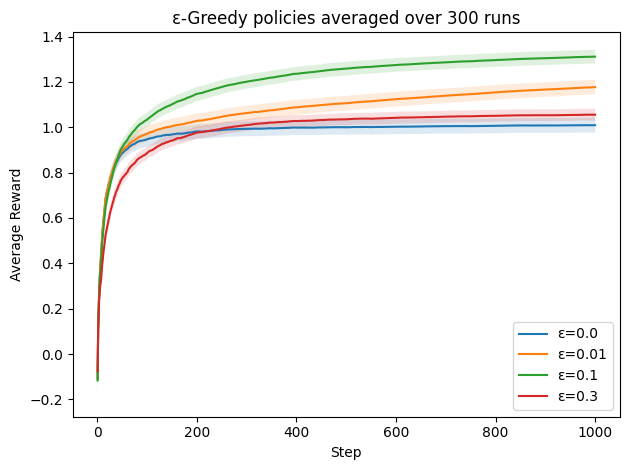

In [38]:
import numpy as np
import matplotlib.pyplot as plt

epsilons = [0.0, 0.01, 0.1, 0.3]
runs = 300
steps = 1000
n_arms = 10
nonstationary = False
drift = 0.01

def run_once(eps, seed):
    env = BanditEnv(n=n_arms, seed=seed, nonstationary=nonstationary, drift=drift)
    agent = EpsilonGreedyAgent(n=n_arms, epsilon=eps)
    r = np.empty(steps, dtype=float)
    for t in range(steps):
        a = agent.act()
        r[t] = env.step(a)
        agent.update(a, r[t])
    # running average reward
    return np.cumsum(r) / np.arange(1, steps+1)

means = {}
stds  = {}

for eps in epsilons:
    curves = np.zeros((runs, steps), dtype=float)
    for i in range(runs):
        seed = 10_000 + i                    # different env per run
        curves[i] = run_once(eps, seed)
    means[eps] = curves.mean(axis=0)
    stds[eps]  = curves.std(axis=0) / np.sqrt(runs)   # standard error

plt.figure()
x = np.arange(1, steps+1)
for eps in epsilons:
    m = means[eps]; s = stds[eps]
    plt.plot(x, m, label=f'ε={eps}')
    # light uncertainty band (no custom color specified)
    plt.fill_between(x, m - s, m + s, alpha=0.15)

plt.xlabel('Step'); plt.ylabel('Average Reward')
plt.title(f'ε-Greedy policies averaged over {runs} runs')
plt.legend()
plt.tight_layout()
plt.show()


## Upper Confidence Bound (UCB)

**Idea:** Pick the action whose estimated mean has an uncertainty bonus.


$\text{UCB}_a(t) \;=\; \hat{\mu}_a(t) \;+\; c\,\sqrt{\frac{\ln t}{N_a(t)}}$

$\hat{\mu}_a(t)$: estimated mean reward of arm \(a\)  

$N_a(t)$: number of pulls of arm \(a\) up to \(t\)  

$c$: exploration constant

**Action rule:**
$
a_t \;=\; \arg\max_a \;\text{UCB}_a(t)
$

## Softmax (Boltzmann) Action Selection

**Idea:** Turn values into probabilities with temperature $\tau$.

$
P(a \mid t) \;=\; \frac{\exp\!\bigl(\hat{\mu}_a(t)/\tau\bigr)}
{\sum_{b} \exp\!\bigl(\hat{\mu}_b(t)/\tau\bigr)}
$

- $\hat{\mu}_a(t)$: estimated mean reward of arm \(a\)  
- $\tau$: temperature (lower = greedier, higher = more exploratory)

**Action rule:**
$
a_t \sim P(a \mid t)
$


In [39]:
class EpsilonGreedyAgent:
    def __init__(self, n, rng, epsilon=0.1, alpha=None):
        self.rng = rng
        self.epsilon = float(epsilon)
        self.alpha = alpha  # if None, uses 1/N; else constant step-size
        self.Q = np.zeros(n, dtype=float)
        self.N = np.zeros(n, dtype=int)
    def act(self):
        if self.rng.random() < self.epsilon:
            return int(self.rng.integers(0, len(self.Q)))
        return int(np.argmax(self.Q))
    def update(self, a, r):
        self.N[a] += 1
        if self.alpha is None:
            self.Q[a] += (r - self.Q[a]) / self.N[a]
        else:
            self.Q[a] += self.alpha * (r - self.Q[a])

class UCBAgent:
    def __init__(self, n, rng, c=2.0, alpha=None):
        self.rng = rng
        self.c = float(c)
        self.alpha = alpha
        self.Q = np.zeros(n, dtype=float)
        self.N = np.zeros(n, dtype=int)
        self.t = 0
    def act(self):
        # try each arm once first
        untried = np.where(self.N == 0)[0]
        if len(untried) > 0:
            return int(self.rng.choice(untried))
        eps = 1e-12
        bonus = self.c * np.sqrt(np.log(max(self.t, 1)) / (self.N + eps))
        return int(np.argmax(self.Q + bonus))
    def update(self, a, r):
        self.t += 1
        self.N[a] += 1
        if self.alpha is None:
            self.Q[a] += (r - self.Q[a]) / self.N[a]
        else:
            self.Q[a] += self.alpha * (r - self.Q[a])

class SoftmaxAgent:
    def __init__(self, n, rng, tau=0.1, alpha=None):
        self.rng = rng
        self.tau = float(tau)
        self.alpha = alpha
        self.Q = np.zeros(n, dtype=float)
        self.N = np.zeros(n, dtype=int)
    def act(self):
        z = (self.Q - np.max(self.Q)) / max(self.tau, 1e-12)
        p = np.exp(z); p /= p.sum()
        return int(self.rng.choice(len(self.Q), p=p))
    def update(self, a, r):
        self.N[a] += 1
        if self.alpha is None:
            self.Q[a] += (r - self.Q[a]) / self.N[a]
        else:
            self.Q[a] += self.alpha * (r - self.Q[a])

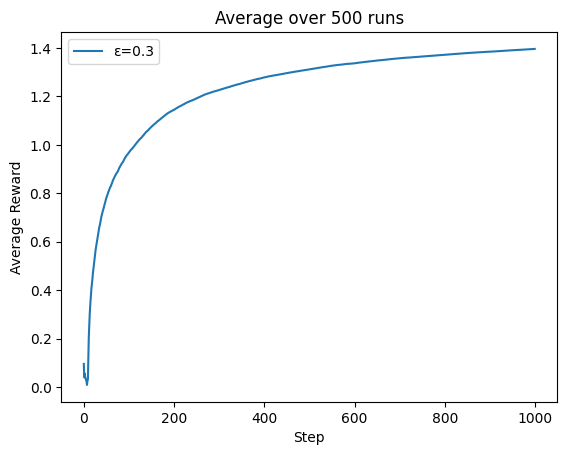

In [40]:

runs = 500          # large number
steps = 1000
n_arms = 10
rng_master = np.random.default_rng(seed)
avg_rewards_all = {eps: np.zeros(steps) for eps in epsilons}

for run in range(runs):
  env = BanditEnv(n=n_arms, seed=run, nonstationary=False)
  agent = UCBAgent(n=n_arms, rng=rng_master, c=2.0)
  for t in range(steps):
    a = agent.act()
    r = env.step(a)
    agent.update(a, r)
    avg_rewards_all[eps][t] += r
avg_rewards_all[eps] /= runs

plt.figure()
avg_reward = np.cumsum(avg_rewards_all[eps]) / np.arange(1, steps+1)
plt.plot(avg_reward, label=f'ε={eps}')
plt.xlabel('Step'); plt.ylabel('Average Reward')
plt.title(f'Average over {runs} runs')
plt.legend()
plt.show()


In [41]:
def run(env, agent, steps=2000):
    rewards = np.zeros(steps, dtype=float)
    optimal = np.zeros(steps, dtype=int)

    # identify the true best arm for % optimal plot
    true_best = int(np.argmax(env.mu))

    for t in range(steps):
        a = agent.act()
        r = env.step(a)
        agent.update(a, r)
        rewards[t] = r
        optimal[t] = (a == true_best)
    return rewards, optimal

# Example usage
n, steps, seed = 10, 2000, 7
rng_master = np.random.default_rng(seed)

env = BanditEnv(n=n, seed=seed, nonstationary=False)
agent_eps  = EpsilonGreedyAgent(n, rng=rng_master, epsilon=0.1)
re_eps, op_eps = run(env, agent_eps, steps=steps)

env = BanditEnv(n=n, seed=seed, nonstationary=False)
agent_ucb  = UCBAgent(n, rng=rng_master, c=2.0)
re_ucb, op_ucb = run(env, agent_ucb, steps=steps)

env = BanditEnv(n=n, seed=seed, nonstationary=False)
agent_soft = SoftmaxAgent(n, rng=rng_master, tau=0.1)
re_soft, op_soft = run(env, agent_soft, steps=steps)


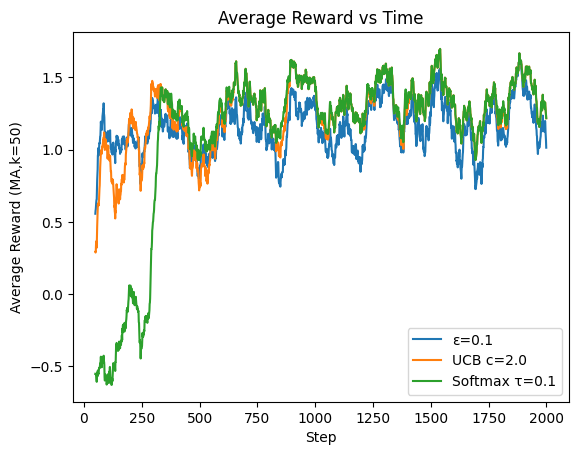

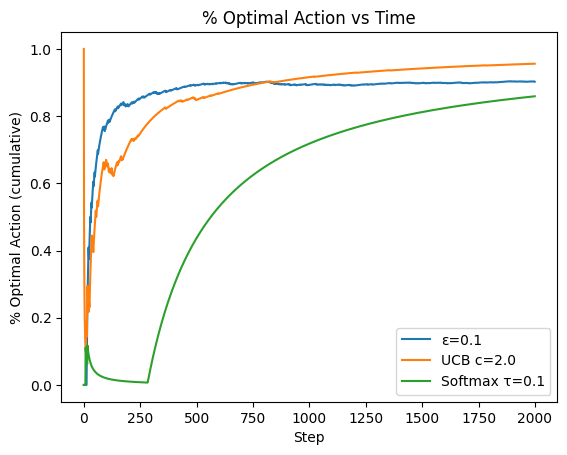

In [42]:
import matplotlib.pyplot as plt
def moving_average(x, k=50):
    k = max(1, int(k))
    c = np.cumsum(np.insert(x, 0, 0.0))
    y = (c[k:] - c[:-k]) / k
    return np.concatenate([np.full(k-1, np.nan), y])

plt.figure()
plt.plot(moving_average(re_eps),  label="ε=0.1")
plt.plot(moving_average(re_ucb),  label="UCB c=2.0")
plt.plot(moving_average(re_soft), label="Softmax τ=0.1")
plt.xlabel("Step"); plt.ylabel("Average Reward (MA,k=50)"); plt.title("Average Reward vs Time"); plt.legend(); plt.show()

plt.figure()
for lab, opt in [("ε=0.1", op_eps), ("UCB c=2.0", op_ucb), ("Softmax τ=0.1", op_soft)]:
    pct = np.cumsum(opt) / np.arange(1, len(opt)+1)
    plt.plot(pct, label=lab)
plt.xlabel("Step"); plt.ylabel("% Optimal Action (cumulative)"); plt.title("% Optimal Action vs Time"); plt.legend(); plt.show()


### Comparison for different values of epsilon
Given these two graphs ('Average over 500 runs' and 'Optimal Action vs Step'), we can conclude the following. In both, it is seen that having a very small Epsilon (0.0), meaning having very little exploration, allows for a significant initial growth, but after a while, it gets stuck and turns out to give the worst results. 

In contrast, having a slightly bigger Epsilon (0.1) shows a satisfactory resulting balance between the amount of exploration and exploitation the algorithm has. It shows an initial growth very similar to the smaller Epsilon, but in this case, it keeps improving the Optimal Action over the course of the steps. 

Finally, when comparing a much bigger value (0.3) it is evident that there is no point in giving the algorithm such a big Epsilon. It gives a slightly better average than the smallest Epsilon, and in the Optimal Action percentage, it stops improving much earlier than with the medium Epsilon. 

### Comparison between Policies
By graphing the same two graphs ('Average over 500 runs' and 'Optimal Action vs Step'), we are able to get a clear pciture for how the different policies allow for the taking of the most optimal actions. 

On one hand, in terms of finding a larger average reward, the three polcies (with the proper parameters), show very similar performances overall. However, it is Softmax which seems to give the biggest average rewards, with certain fluctuations but better than the others. 

On the other hand, the best optimal action taking, is between Greedy and UCB. However, it is UCB which has the biggest improvemment overall and less fluctuations. Once it reaches a certain high, it keeps a steady optimal action. 

## Discussion about c y τ parameters
For the parameters c (in UCB) and τ (in Softmax) can also control the balance between exploration and exploitation. For the UCB, a larger c means the agent has a bigger tendency to explore, while a small c means it goes for the high-value arms only. The way it does this, is by expanding or retractcting the confidence bounds of the algorithms. 

For the τ in the Softmax algorithm, the same balance is achieved by controling how "random" the action selection is. A high τ makes the probability distribution over arms more uniform (more exploration), while a lower τ allows less randomness. 

## Conclusion
From these experiments, we can see that the choice of parameters plays a crucial role in balancing exploration and exploitation. For greedy algorithm, medium and smaller epsilon values allow for the highest proportion of optimal actions over time. When comparing policies, UCB shows strong consistency in identifying and sticking with the optimal arm, while Softmax can achieve slightly higher average rewards but with more variability depending on τ. Overall, it can be said that there is not one single solution for every case; it depends on what the requirements are and the available parameters. 